In [1]:
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np
from sklearn.metrics import roc_curve, auc

In [3]:
df = pd.read_csv(r"C:\Users\shubham\Anaconda_Files\bankdata.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
age          4521 non-null int64
job          4521 non-null object
marital      4521 non-null object
education    4521 non-null object
default      4521 non-null object
balance      4521 non-null int64
housing      4521 non-null object
loan         4521 non-null object
contact      4521 non-null object
day          4521 non-null int64
month        4521 non-null object
duration     4521 non-null int64
campaign     4521 non-null int64
pdays        4521 non-null int64
previous     4521 non-null int64
poutcome     4521 non-null object
y            4521 non-null object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [5]:
df['target'] = df['y'].apply(lambda x : 1 if x == 'yes' else 0)  # Convert to numeric
df = df.drop('y',axis=1) #drop the y column

In [6]:
df['target'].value_counts()

0    4000
1     521
Name: target, dtype: int64

### I am going to use a quick way to encode the class variables (Label Encoder). Since some of the variables in the train dataframe categories

In [ ]:
# Data transformation
# Convert categorical values to numeric using label encoder
from sklearn import preprocessing
from collections import defaultdict
d = defaultdict(preprocessing.LabelEncoder)
# Encoding the categorical variable
fit = df.select_dtypes(include=['object']).apply(lambda x: d[x.name].fit_transform(x))

#Convert the categorical columns based on encoding
for i in list(d.keys()):
    df[i] = d[i].transform(df[i])

In [10]:
features = df[df.columns.difference(['target'])]
labels = df['target']

# Variable Selection

### 1. Weight of Evidence and Information Value

In [11]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)


In [12]:
final_iv, IV = data_vars(df,df.target)

In [13]:
final_iv

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,age,19,39,2290,259,0.113100,2031,0.886900,0.497121,0.50775,-0.021156,0.000452
1,age,40,87,2231,262,0.117436,1969,0.882564,0.502879,0.49225,0.021363,0.000452
2,job,0,4,2673,287,0.107370,2386,0.892630,0.550864,0.59650,-0.079592,0.008522
3,job,5,11,1848,234,0.126623,1614,0.873377,0.449136,0.40350,0.107150,0.008522
4,marital,0,1,3325,354,0.106466,2971,0.893534,0.679463,0.74275,-0.089057,0.019556
5,marital,2,2,1196,167,0.139632,1029,0.860368,0.320537,0.25725,0.219951,0.019556
6,education,0,1,2984,309,0.103552,2675,0.896448,0.593090,0.66875,-0.120064,0.024649
7,education,2,3,1537,212,0.137931,1325,0.862069,0.406910,0.33125,0.205718,0.024649
8,default,0,0,4445,512,0.115186,3933,0.884814,0.982726,0.98325,-0.000534,0.000016
9,default,1,1,76,9,0.118421,67,0.881579,0.017274,0.01675,0.030832,0.000016


In [14]:
IV = IV.rename(columns={'VAR_NAME':'index'})

In [15]:
IV.sort_values(['IV'],ascending=0)

,index,IV
6,duration,1.651501
3,contact,0.247734
13,pdays,0.203267
15,previous,0.177081
8,housing,0.106556
1,balance,0.076208
10,loan,0.060791
7,education,0.024649
2,campaign,0.023342
11,marital,0.019556


## 2. Variable Importance

In [76]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(features,labels)

preds = clf.predict(features)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,labels)
print(accuracy)

0.9900464499004645


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [77]:
from pandas import DataFrame
VI = DataFrame(clf.feature_importances_, columns = ["RF"], index=features.columns)

In [78]:
VI = VI.reset_index()

In [79]:
VI.sort_values(['RF'],ascending=0)

,index,RF
6,duration,0.31
0,age,0.10
1,balance,0.10
4,day,0.09
12,month,0.08
9,job,0.05
13,pdays,0.05
2,campaign,0.04
14,poutcome,0.04
7,education,0.03


### 3. Recursive Feature Elimination

In [80]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
rfe = RFE(model, 20)
fit = rfe.fit(features, labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [81]:
from pandas import DataFrame
Selected = DataFrame(rfe.support_, columns = ["RFE"], index=features.columns)
Selected = Selected.reset_index()

In [82]:
Selected[Selected['RFE'] == True]

,index,RFE
0,age,True
1,balance,True
2,campaign,True
3,contact,True
4,day,True
5,default,True
6,duration,True
7,education,True
8,housing,True
9,job,True


### 4. Chi Square

In [83]:
df1 = df.copy()

from sklearn import preprocessing
from collections import defaultdict
d = defaultdict(preprocessing.LabelEncoder)
# Encoding the categorical variable
fit = df1.apply(lambda x: d[x.name].fit_transform(x))

#Convert the categorical columns based on encoding
for i in list(d.keys()):
    df1[i] = d[i].transform(df1[i])

In [84]:
features1 = df1[df1.columns.difference(['target'])]
labels1 = df1['target']

In [85]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

model = SelectKBest(score_func=chi2, k=5)
fit = model.fit(features1, labels1)

In [86]:
import numpy
numpy.set_printoptions(suppress=True)
print(fit.scores_)

[    45.84063034  11343.97706276     88.07290162    100.51007877
      2.60631502      0.00754274 119483.9344331       3.80267508
     21.50080127      8.15459672     19.04525811      0.32039715
     12.32541175   5374.89961779     11.86870754    330.26034213]


In [87]:
from pandas import DataFrame
pd.options.display.float_format = '{:.2f}'.format
chi_sq = DataFrame(fit.scores_, columns = ["Chi_Square"], index=features1.columns)

In [88]:
chi_sq = chi_sq.reset_index()

In [89]:
chi_sq.sort_values('Chi_Square',ascending=0)

,index,Chi_Square
6,duration,119483.93
1,balance,11343.98
13,pdays,5374.90
15,previous,330.26
3,contact,100.51
2,campaign,88.07
0,age,45.84
8,housing,21.50
10,loan,19.05
12,month,12.33


### 3.7 Combine all together

In [90]:
from functools import reduce
dfs = [IV, VI, Selected, chi_sq]
final_results = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs)

In [91]:
final_results.head()

,index,IV,RF,RFE,Chi_Square
0,age,0.00,0.10,True,45.84
1,balance,0.08,0.10,True,11343.98
2,campaign,0.02,0.04,True,88.07
3,contact,0.25,0.02,True,100.51
4,day,0.00,0.09,True,2.61


In [92]:

final_results.columns

Index(['index', 'IV', 'RF', 'RFE', 'Chi_Square'], dtype='object')

In [93]:
columns = ['IV', 'RF', 'Chi_Square']

score_table = pd.DataFrame({},[])
score_table['index'] = final_results['index']

for i in columns:
    score_table[i] = final_results['index'].isin(list(final_results.nlargest(5,i)['index'])).astype(int)
    
score_table['RFE'] = final_results['RFE'].astype(int)


In [94]:
score_table['final_score'] = score_table.sum(axis=1)

In [95]:
score_table.sort_values('final_score',ascending=0)

,index,IV,RF,Chi_Square,RFE,final_score
6,duration,1,1,1,1,4
1,balance,0,1,1,1,3
3,contact,1,0,1,1,3
13,pdays,1,0,1,1,3
15,previous,1,0,1,1,3
0,age,0,1,0,1,2
4,day,0,1,0,1,2
8,housing,1,0,0,1,2
12,month,0,1,0,1,2
2,campaign,0,0,0,1,1


### 1. Multicollinearity - VIF 

In [96]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [97]:
def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

In [98]:
vif = calculate_vif(features)
while vif['VIF'][vif['VIF'] > 10].any():
    remove = vif.sort_values('VIF',ascending=0)['Features'][:1]
    features.drop(remove,axis=1,inplace=True)
    vif = calculate_vif(features)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [99]:
vif

,Features,VIF
0,age,7.75
1,balance,1.26
2,campaign,1.87
3,contact,1.99
4,day,4.55
5,default,1.03
6,duration,2.00
7,education,3.64
8,housing,2.52
9,job,2.88


### 2. Multicollinearity - VIF 

In [100]:
features = df[df.columns.difference(['target', 'age'])]
def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

vif = calculate_vif(features)
while vif['VIF'][vif['VIF'] > 10].any():
    remove = vif.sort_values('VIF',ascending=0)['Features'][:1]
    features.drop(remove,axis=1,inplace=True)
    vif = calculate_vif(features)
    
vif

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Features,VIF
0,balance,1.23
1,campaign,1.83
2,contact,1.97
3,day,4.04
4,default,1.03
5,duration,1.91
6,education,3.51
7,housing,2.52
8,job,2.73
9,loan,1.18


### Distribution of pdays

In [131]:
df['pdays'].value_counts()

-1      3705
 182      23
 183      20
 363      12
 92       12
 91       11
 169      10
 181      10
 370       9
 364       9
 349       8
 167       8
 99        8
 94        8
 184       7
 2         7
 176       7
 172       7
 175       6
 87        6
 345       6
 185       6
 95        6
 152       6
 173       6
 342       6
 96        6
 85        6
 150       6
 351       6
        ... 
 541       1
 397       1
 385       1
 341       1
 329       1
 313       1
 305       1
 265       1
 225       1
 205       1
 687       1
 118       1
 386       1
 158       1
 382       1
 378       1
 374       1
 294       1
 282       1
 262       1
 254       1
 250       1
 242       1
 238       1
 234       1
 222       1
 210       1
 206       1
 162       1
 28        1
Name: pdays, Length: 292, dtype: int64

### Model Iter1 : Build Logistic Regression Model using top 4 variables 

In [132]:
feature_cols = ['duration','balance','contact','previous']

X = df[feature_cols] # Features
Y = df['target'] # Target variable

# manually add the intercept
#X['intercept'] = 1.0
X = sm.add_constant(X) 

result = sm.Logit(Y, X).fit()

print_model = result.summary()
print(print_model)

np.exp(result.params)
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print(np.exp(conf))

Optimization terminated successfully.
         Current function value: 0.283247
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 4521
Model:                          Logit   Df Residuals:                     4516
Method:                           MLE   Df Model:                            4
Date:                Thu, 29 Aug 2019   Pseudo R-squ.:                  0.2073
Time:                        23:49:55   Log-Likelihood:                -1280.6
converged:                       True   LL-Null:                       -1615.5
Covariance Type:            nonrobust   LLR p-value:                1.159e-143
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1524      0.096    -32.958      0.000      -3.340      -2.965
duration       0.0037      0.

### create bin variable for "duration"

In [134]:
   #Let's look the Credit Amount column

df['duration_cat'] = 'le62'
df.loc[(df['duration'] > 62) & (df['duration'] <= 500), 'duration_cat'] = 'le500'
df.loc[(df['duration'] > 500) & (df['duration'] <= 10000), 'duration_cat'] = 'gt500'


#Purpose to Dummies Variable
df = df.merge(pd.get_dummies(df.duration_cat, drop_first=True, prefix='duration'), left_index=True, right_index=True)

df['balance_divide_by100'] = 0
df.loc[(df['balance'] > 0), 'balance_divide_by100'] = df['balance'] / 1000
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,duration_le62_x,balance_divide_by100,duration_le500_y,duration_le62_y,duration_le500_x,duration_le62_x,duration_le500_y,duration_le62_y,duration_le500,duration_le62
0,30,10,1,0,0,1787,0,0,0,19,...,0,1.79,1,0,1,0,1,0,1,0
1,33,7,1,1,0,4789,1,1,0,11,...,0,4.79,1,0,1,0,1,0,1,0
2,35,4,2,2,0,1350,1,0,0,16,...,0,1.35,1,0,1,0,1,0,1,0
3,30,4,1,2,0,1476,1,1,2,3,...,0,1.48,1,0,1,0,1,0,1,0
4,59,1,1,1,0,0,1,0,2,5,...,0,0.00,1,0,1,0,1,0,1,0


### Model Iter 2: Run on derived variables with same 4 variables

In [135]:
#split dataset in features and target variable
feature_cols = ['duration_le500', 'duration_le62', 'balance_divide_by100', 'contact',  'previous']
X = df[feature_cols] # Features
y = df['target'] # Target variable

# manually add the intercept
#X['intercept'] = 1.0
X = sm.add_constant(X) 

result = sm.Logit(Y, X).fit()

print_model = result.summary()
print(print_model)

np.exp(result.params)
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print(np.exp(conf))

Optimization terminated successfully.
         Current function value: 0.295203
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 4521
Model:                          Logit   Df Residuals:                     4515
Method:                           MLE   Df Model:                            5
Date:                Thu, 29 Aug 2019   Pseudo R-squ.:                  0.1739
Time:                        23:52:30   Log-Likelihood:                -1334.6
converged:                       True   LL-Null:                       -1615.5
Covariance Type:            nonrobust   LLR p-value:                3.669e-119
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2462      0.098     -2.511      0.012      -0.438      -0.05

### Model Iter 3 : Drop variable Balance since relatively low significance

In [136]:
#split dataset in features and target variable
feature_cols = ['duration_le500', 'duration_le62', 'contact', 'previous']
X = df[feature_cols] # Features
y = df['target'] # Target variable

# manually add the intercept
#X['intercept'] = 1.0
X = sm.add_constant(X) 

result = sm.Logit(Y, X).fit()

print_model = result.summary()
print(print_model)

np.exp(result.params)
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print(np.exp(conf))

Optimization terminated successfully.
         Current function value: 0.295514
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 4521
Model:                          Logit   Df Residuals:                     4516
Method:                           MLE   Df Model:                            4
Date:                Thu, 29 Aug 2019   Pseudo R-squ.:                  0.1730
Time:                        23:53:02   Log-Likelihood:                -1336.0
converged:                       True   LL-Null:                       -1615.5
Covariance Type:            nonrobust   LLR p-value:                1.178e-119
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.2127      0.096     -2.212      0.027      -0.401      -0.024
duration_le500  

# Following code has been used for generating ROC and Confusion Matrix

## Model Iter 1 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.8922804689228047
Precision: 0.6089743589743589
Recall: 0.18234165067178504
F1-Score: 0.28064992614475626


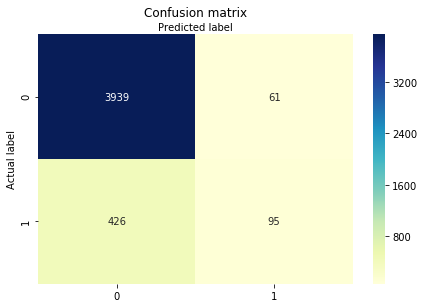

In [152]:
feature_cols = ['duration','balance','contact','previous']

X = df[feature_cols] # Features
Y = df['target'] # Target variable

# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X,Y)

#
y_pred=logreg.predict(X)

# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(Y, y_pred)
cnf_matrix

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Precision = metrics.precision_score(Y, y_pred)
Recall = metrics.recall_score(Y, y_pred)
F1 = 2 * (Precision * Recall) / (Precision + Recall)

#### Model fit Stats
print("Accuracy:",metrics.accuracy_score(Y, y_pred))
print("Precision:",metrics.precision_score(Y, y_pred))
print("Recall:",metrics.recall_score(Y, y_pred))
print("F1-Score:",F1)



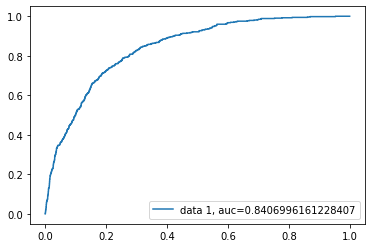

In [153]:
##### ROC
y_pred_proba = logreg.predict_proba(X)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y,  y_pred_proba)
auc = metrics.roc_auc_score(Y, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Model Iter 2

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.8834328688343287
Precision: 0.453125
Recall: 0.05566218809980806
F1-Score: 0.09914529914529914


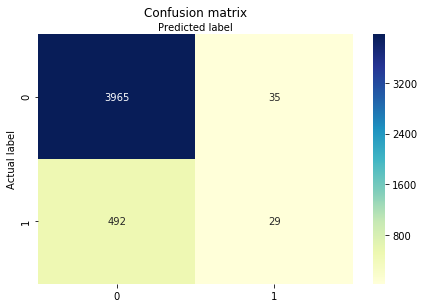

In [154]:
feature_cols = ['duration_le500', 'duration_le62', 'balance_divide_by100', 'contact',  'previous']
X = df[feature_cols] # Features
y = df['target'] # Target variable

# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X,Y)

#
y_pred=logreg.predict(X)

# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(Y, y_pred)
cnf_matrix

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Precision = metrics.precision_score(Y, y_pred)
Recall = metrics.recall_score(Y, y_pred)
F1 = 2 * (Precision * Recall) / (Precision + Recall)

#### Model fit Stats
print("Accuracy:",metrics.accuracy_score(Y, y_pred))
print("Precision:",metrics.precision_score(Y, y_pred))
print("Recall:",metrics.recall_score(Y, y_pred))
print("F1-Score:",F1)



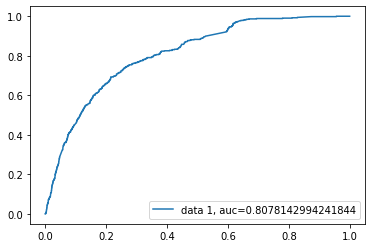

In [155]:
##### ROC
y_pred_proba = logreg.predict_proba(X)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y,  y_pred_proba)
auc = metrics.roc_auc_score(Y, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Model Iter 3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.8829904888299049
Precision: 0.43103448275862066
Recall: 0.04798464491362764
F1-Score: 0.08635578583765112


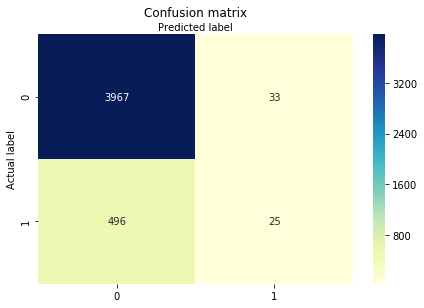

In [156]:
feature_cols = ['duration_le500', 'duration_le62', 'contact', 'previous']
X = df[feature_cols] # Features
y = df['target'] # Target variable

# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X,Y)

#
y_pred=logreg.predict(X)

# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(Y, y_pred)
cnf_matrix

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Precision = metrics.precision_score(Y, y_pred)
Recall = metrics.recall_score(Y, y_pred)
F1 = 2 * (Precision * Recall) / (Precision + Recall)

#### Model fit Stats
print("Accuracy:",metrics.accuracy_score(Y, y_pred))
print("Precision:",metrics.precision_score(Y, y_pred))
print("Recall:",metrics.recall_score(Y, y_pred))
print("F1-Score:",F1)



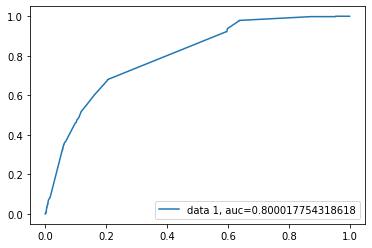

In [157]:
##### ROC
y_pred_proba = logreg.predict_proba(X)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y,  y_pred_proba)
auc = metrics.roc_auc_score(Y, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()